In [1]:
import csv
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix, classification_report
from google_drive_downloader import GoogleDriveDownloader as gdd

In [2]:
class TruthDiscovery():
  def __init__(self):
    self.dataframe = pd.DataFrame()

  def calculate_score(self, source_list, claim_list, df):
    scores = []
    for sr in source_list:
      s = []
      for c in claim_list:
        if c in data[data["source_url"] == sr].idiom_claims.values.tolist():
          s.append(1)
        else:
          s.append(0)
      scores.append(s)
    claim = pd.DataFrame(scores, columns=claim_list)
    source = pd.DataFrame([[s] for s in source_list], columns=['source_url'])
    data_score = pd.concat([source, claim], axis=1)
    return scores, data_score

  def calculate_vs_score(self, scores):
    Vs_count_list = []
    for i in scores:
      Vs = 0
      for j in i:
        if j == 1:
          Vs = Vs + 1
      Vs_count_list.append(Vs)
    return Vs_count_list

  def inisialisasi_claim_score(self, factor, scores):
    new_scores = scores
    for i in range(len(new_scores)):
      for j in range(len(new_scores[0])):
        new_scores[i][j] *= factor
    return new_scores

  def calculate_source_score(self, Vs_count_list, new_scores, isAvgLog):
    source_score_list = []
    for i in range(len(new_scores)):
      sum = 0
      for j in range(len(new_scores[i])):
        sum = sum + new_scores[i][j]
        
      if(isAvgLog):
        sum = (math.log10(Vs_count_list[i]))*(sum/Vs_count_list[i])

      source_score_list.append(sum)

      for j in range(len(new_scores[i])):
        if new_scores[i][j] > 0:
          new_scores[i][j] = sum
    return source_score_list, new_scores

  def calculate_claim_score(self, new_scores):
    claim_score_list = []
    for i in range(len(new_scores[0])):
      sum = 0
      for j in range(len(new_scores)):
        sum = sum + new_scores[j][i]
        
      claim_score_list.append(sum)

      for j in range(len(new_scores)):
        if new_scores[j][i] > 0:
          new_scores[j][i] = sum
    return claim_score_list, new_scores

  def set_source_score(self, df, source_list, source_score_list):
    index = df.index
    index_column = df.columns.get_loc('source_score')
    for i in range(len(source_list)):
      condition = df['source_url'] == source_list[i]
      indices = index[condition].tolist()
      df.iloc[indices,[index_column]] = source_score_list[i]
    return df

  def set_claim_score(self, df, claim_list, claim_score_list):
    index = df.index
    index_column = df.columns.get_loc('claim_score')
    for i in range(len(claim_list)):
      condition = df['idiom_claims'] == claim_list[i]
      indices = index[condition].tolist()
      df.iloc[indices,[index_column]] = claim_score_list[i]
    return df

  def fit(self, df, factor, isAvgLog, iteration):
    source_list = df["source_url"].drop_duplicates().values.tolist()
    claim_list = df["idiom_claims"].drop_duplicates().values.tolist()

    scores = self.calculate_score(source_list, claim_list, df)[0]
    Vs_count_list = self.calculate_vs_score(scores)
    new_scores = self.inisialisasi_claim_score(factor, scores)
    
    source_score_list = []
    claim_score_list = []

    for i in range(iteration):
      hasil_cal_source = self.calculate_source_score(Vs_count_list, new_scores, isAvgLog)
      source_score_list = hasil_cal_source[0]
      new_scores = hasil_cal_source[1]
      
      hasil_cal_claim = self.calculate_claim_score(new_scores)
      claim_score_list = hasil_cal_claim[0]
      new_scores = hasil_cal_claim[1]

    new_df = df.copy()
    new_df['source_score'] = 0
    new_df['claim_score'] = 0
    
    new_df = self.set_source_score(new_df, source_list, source_score_list)
    new_df = self.set_claim_score(new_df, claim_list, claim_score_list)

    self.dataframe = new_df
    return new_df

  def _predict(self, x):
    w = x.split(' ')
    r = w[0] + '(.*?)' + w[1]
    l = self.dataframe[self.dataframe['idiom_claims'].str.contains(r, na=False)]
    score = l['claim_score'].max()
    label = 0
    batas = (self.dataframe['claim_score'].max() - self.dataframe['claim_score'].max()) * 0.5
    if math.isnan(score) == False:
      if score > batas:
        label = 1
      else:
        label = 0
    else:
      label = 0
    return label

  def predict(self, X):
    predicted_labels = [self._predict(x) for x in X]
    return predicted_labels

#Download & Load Data
Drive link : https://drive.google.com/file/d/1Z7mz2Bn8mwAUrIuxVLk0ndg-2to7sAiK/view?usp=sharing

In [3]:
gdd.download_file_from_google_drive(file_id='1Z7mz2Bn8mwAUrIuxVLk0ndg-2to7sAiK',
                                    dest_path='content/Source_website_idiom.zip',
                                    unzip=True)

Unzipping...Done.


In [4]:
data = pd.read_csv("/content/content/Source_website_idiom/Source_website_idiom.csv")
data

,source_web,source_url,idiom_claims,arti
0,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,Adu Mulut,Bertengkar
1,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,Akal Bulus,Tipu Muslihat Yang Licik
2,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,Ambang Pintu,Saat Mendekatnya Peristiwa Atau Kejadian
3,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,Anak Bawang,Peserta Bermain Yang Tidak Masuk Hitungan
4,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,Anak Buah,Bawahan Seorang Pemimpin
...,...,...,...,...
4353,id.wiktionary.org,https://id.wiktionary.org/wiki/Kategori:id:Ist...,tebal telinga,NaN
4354,id.wiktionary.org,https://id.wiktionary.org/wiki/Kategori:id:Ist...,ujung hidung,NaN
4355,id.wiktionary.org,https://id.wiktionary.org/wiki/Kategori:id:Ist...,ujung kuku,NaN
4356,id.wiktionary.org,https://id.wiktionary.org/wiki/Kategori:id:Ist...,ujung pangkal,NaN


In [5]:
data['idiom_claims'] = data['idiom_claims'].str.casefold()
data['idiom_claims'] = data['idiom_claims'].str.strip()

In [6]:
len(data['idiom_claims'])

4358

In [7]:
sc = data.groupby(['source_url'], sort=False, as_index=False).size()
sc

,source_url,size
0,https://salamadian.com/contoh-ungkapan-bahasa-...,207
1,https://dosenbahasa.com/idiom,46
2,https://dosenbahasa.com/jenis-jenis-idiom-dala...,39
3,https://dosenbahasa.com/contoh-ungkapan-besert...,35
4,https://dosenbahasa.com/contoh-makna-kias,50
...,...,...
99,http://p2k.unhamzah.ac.id/ind/3073-2970/Daftar...,109
100,https://www.ayo-berbahasa.id/2020/11/contoh-fr...,22
101,https://brainly.co.id/tugas/17873723/,30
102,https://majalahpendidikan.com/contoh-frasa-idi...,8


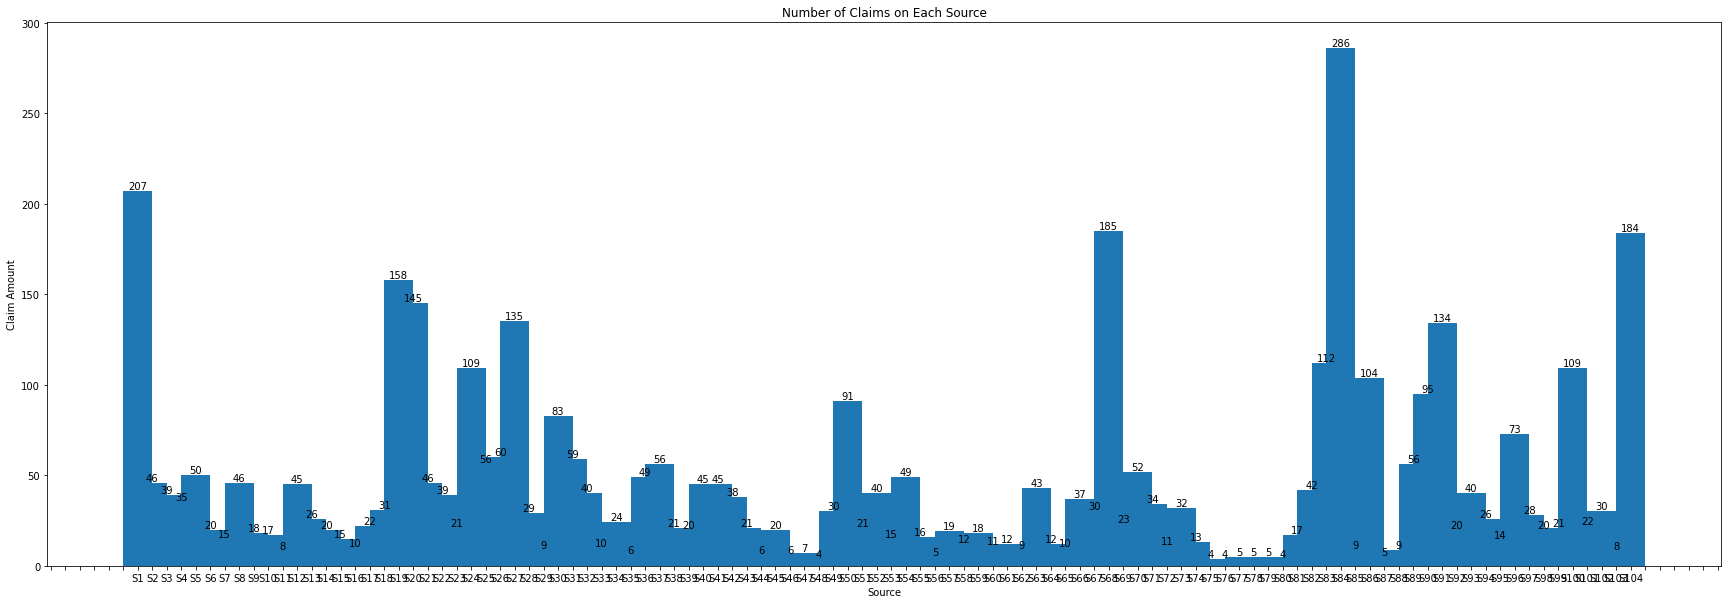

In [8]:
fig, ax = plt.subplots(figsize=(30,10))
#fig = plt.figure(figsize=(50,10))
#ax = fig.add_subplot(321)
source = ['S' + str(i+1) for i in range(len(sc['source_url']))]
source_claims = sc['size']
bars = ax.bar(source, source_claims, width=2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
for bar in bars:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax.text(label_x_pos, height, s=f'{height}', ha='center',
  va='bottom')

plt.title('Number of Claims on Each Source')
plt.xlabel('Source')
plt.ylabel('Claim Amount')
plt.show()

In [12]:
model = TruthDiscovery()

In [14]:
source_list = data["source_url"].drop_duplicates().values.tolist()
claim_list = data["idiom_claims"].drop_duplicates().values.tolist()

In [15]:
k = model.calculate_score(source_list, claim_list, data)[1]
k

,source_url,adu mulut,akal bulus,ambang pintu,anak bawang,anak buah,anak emas,anak semata wayang,angkat bicara,angkat kaki,angkat tangan,angkat topi,aral melintang,asam garam,awan hitam,awan kelabu,banting tulang,banyak mulut,batu loncatan,bau kencur,benang kusut,benang merah,bengkok hati,berat hati,berat sebelah,berbadan dua,berbunga bunga,berdarah dingin,bermuka dua,berpangku tangan,bersilat lidah,besar hati,besar kepala,besar mulut,biang keladi,bintang kelas,bogem mentah,buah bibir,buah hati,buah pena,...,kejatuhan bualan,darah baru,menjaga lidah,ayam kurik,berpandangan luas,bertolak pinggang,berumur panjang,iri hati,kelas teri,memberi hati,memikat hati,mengambil allih,daya upaya bulus,ambil cakap,ambil kaki,ambil tangan,ambil topi,akbar hati,akbar kepala,akbar mulut,perlintasan pintas,jiwa akbar,bebas tangan,bebas dari ingatan daratan,bebas dari ingatan diri,mulut akbar,beralih muka,beranak cucu,bertekuk lutut,berubah akal,jalan serong,jurang kehidupan,kambing congek,kandang harimau,kepala berat,ebar mulut,masuk angin,mengasah pikiran,tebal kulit,tebal lidah
0,https://salamadian.com/contoh-ungkapan-bahasa-...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,https://dosenbahasa.com/idiom,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,https://dosenbahasa.com/jenis-jenis-idiom-dala...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,https://dosenbahasa.com/contoh-ungkapan-besert...,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,https://dosenbahasa.com/contoh-makna-kias,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,http://p2k.unhamzah.ac.id/ind/3073-2970/Daftar...,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100,https://www.ayo-berbahasa.id/2020/11/contoh-fr...,0,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
101,https://brainly.co.id/tugas/17873723/,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102,https://majalahpendidikan.com/contoh-frasa-idi...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
train = model.fit(df=data, factor=0.5, isAvgLog=True, iteration=3)

In [ ]:
train

Data Test Link : https://drive.google.com/file/d/149oVxg_kjfZmYGNka3DVzN9hz_wOLQc5/view?usp=sharing

In [17]:
gdd.download_file_from_google_drive(file_id='149oVxg_kjfZmYGNka3DVzN9hz_wOLQc5',
                                    dest_path='content/Frasa_bahasa_indonesia.zip',
                                    unzip=True)

Unzipping...Done.


In [18]:
data_test = pd.read_csv("/content/content/Frasa_bahasa_indonesia/Frasa_bahasa_indonesia.csv")
data_test

,frasa,label
0,abad keemasan,frasa biasa
1,abu tulang,frasa biasa
2,adem ayem,frasa biasa
3,adik bungsu,frasa biasa
4,adik ipar,frasa biasa
...,...,...
995,bermuka masam,frasa idiom
996,bermental baja,frasa idiom
997,bunga bank,frasa idiom
998,adu domba,frasa idiom


In [19]:
label = data_test["label"].drop_duplicates().values.tolist()
label

['frasa biasa', 'frasa idiom']

In [20]:
data_test['frasa'] = data_test['frasa'].str.casefold()
data_test['frasa'] = data_test['frasa'].str.strip()

In [21]:
data_test.groupby(['label']).size()

label
frasa biasa    445
frasa idiom    555
dtype: int64

In [22]:
label_cat = {"label":{'frasa biasa' : 0, 'frasa idiom' : 1}}
data_test = data_test.replace(label_cat)
data_test

,frasa,label
0,abad keemasan,0
1,abu tulang,0
2,adem ayem,0
3,adik bungsu,0
4,adik ipar,0
...,...,...
995,bermuka masam,1
996,bermental baja,1
997,bunga bank,1
998,adu domba,1


In [23]:
X = data_test["frasa"].values.tolist()
X[:5]

['abad keemasan', 'abu tulang', 'adem ayem', 'adik bungsu', 'adik ipar']

In [24]:
Y = data_test["label"].values.tolist()
Y[:5]

[0, 0, 0, 0, 0]

In [25]:
print(len(X))
print(len(Y))

1000
1000


In [26]:
predicted_label = model.predict(X)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [ ]:
predicted_label

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [29]:
print('Accuracy:', accuracy_score(Y, predicted_label))
print('F1 score:', f1_score(Y, predicted_label))
print('Recall:', recall_score(Y, predicted_label))
print('Precision:', precision_score(Y, predicted_label))

Accuracy: 0.842
F1 score: 0.855045871559633
Recall: 0.8396396396396396
Precision: 0.8710280373831776


In [30]:
accuracy = round((accuracy_score(Y, predicted_label)*100), 2)
f1_score = round((f1_score(Y, predicted_label)*100), 2)
recall = round((recall_score(Y, predicted_label)*100), 2)
precision = round((precision_score(Y, predicted_label)*100), 2)
list_val = [[accuracy, precision, recall, f1_score]]
evaluasi = pd.DataFrame(list_val,
                        columns=['accuracy', 'precision', 'recall', 'f1_score'])
evaluasi

,accuracy,precision,recall,f1_score
0,84.2,87.1,83.96,85.5


In [31]:
print(classification_report(Y, predicted_label, target_names=label))
pd.DataFrame(confusion_matrix(Y, predicted_label), index=label, columns=label)

              precision    recall  f1-score   support

 frasa biasa       0.81      0.84      0.83       445
 frasa idiom       0.87      0.84      0.86       555

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



,frasa biasa,frasa idiom
frasa biasa,376,69
frasa idiom,89,466


In [34]:
pred = model.predict(['berputih tulang'])
pred

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


[1]

In [37]:
import dill
# save model
filename = 'truth_discovery.dill'
with open(filename, 'wb') as f:
    dill.dump(model, f)

In [38]:
# load model
with open(filename, 'rb') as f:
    td_model = dill.load(f)

In [39]:
pred = td_model.predict(['berputih tulang'])
pred

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


[1]